In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define directories
train_data_dir = 'fer2013/train'
val_data_dir = 'fer2013/val'

### Data Loading and Pre Processing

In [3]:
BATCH_SIZE = 64
INPUT_SIZE = (224, 224)

# Data generators
train_datagen = ImageDataGenerator(preprocessing_function=None, horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=None)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', color_mode='rgb'
)

val_generator = test_datagen.flow_from_directory(
    val_data_dir, target_size=INPUT_SIZE,
    batch_size=BATCH_SIZE, class_mode='categorical', color_mode='rgb'
)

def preprocess_fer2013(image):
    # Convert grayscale image to RGB by repeating the single channel across 3 channels
    image = np.repeat(image[..., np.newaxis], 3, axis=-1)
    return image

preprocessing_function = preprocess_fer2013

Found 28474 images belonging to 7 classes.
Found 7022 images belonging to 7 classes.


### Data Visualization

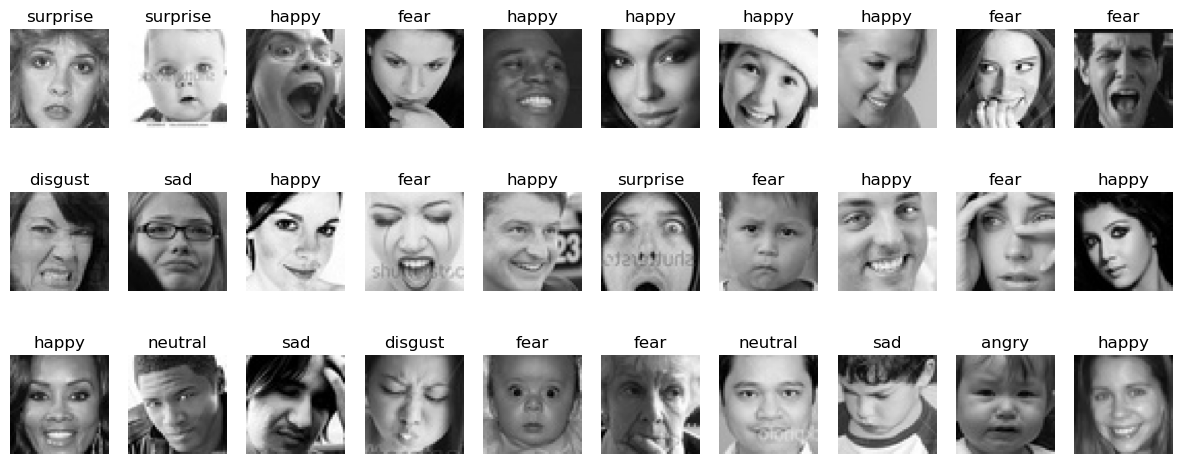

In [4]:
# Get a batch of images and labels from the generator
images, labels = next(train_generator)

num_images = 30 
images_per_row = 10
num_rows = num_images // images_per_row

# Create the figure with a grid of subplots
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 6))

# Get the class labels from the class_indices
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()} # Map index to class name

for i in range(num_images):
    row = i // images_per_row 
    col = i % images_per_row 
    ax = axes[row, col] # Access the appropriate subplot
    
    ax.imshow(images[i].astype('uint8'))  # Convert float to uint8
    ax.axis('off')
    
    # Get the label index and map it to the subdirectory name
    label_index = np.argmax(labels[i])  # The index of the class label
    class_name = class_names[label_index]  # Map the index to the class name
    
    ax.set_title(class_name) # Display label

plt.show()


In [5]:
# Mapping Class Indices to Class Labels
class_to_idx=val_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


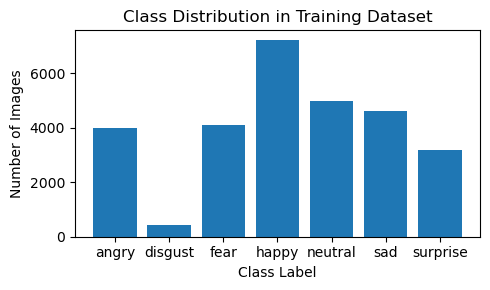

In [9]:
# Get the class labels and the corresponding indices
class_indices = train_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}  # Map index to class name

# Get the class labels for all images in the dataset
labels = train_generator.classes

# Calculate the number of samples in each class
class_counts = [np.sum(labels == i) for i in range(len(class_names))]

# Plot the class distribution
plt.figure(figsize=(5, 3))
plt.bar(class_names.values(), class_counts)
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Dataset')
plt.tight_layout()
plt.show()

#### Calculating Class Weights

In [10]:
# Calculating Class Weights (balance the classes that are underrepresented)
(unique, counts) = np.unique(train_generator.classes, return_counts=True)
cw=1/counts
cw/=cw.min()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights, idx_to_class, val_generator.class_indices)

[3995  436 4097 7214 4965 4596 3171] {0: 1.8057571964956194, 1: 16.545871559633028, 2: 1.7608005857944837, 3: 1.0, 4: 1.4529707955689828, 5: 1.5696257615317666, 6: 2.2749921160517186} {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'} {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


###  Load base model

In [ ]:

# Load the base model
base_model = load_model('face_detection.h5', compile=False)

base_model.summary()

net_description = 'mobilenet_face' # checkpoints name 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 225, 225, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Changing the last layers

In [ ]:
# Removing the last layers
output_layer = base_model.get_layer('feats').output

# Add new dense layer for emotion predictions
emotion_preds = Dense(7, activation='softmax', name='emotion_preds')(output_layer)

# Create the new model
model = Model(inputs=base_model.input, outputs=emotion_preds, name="model_2")

# Compile the new model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the updated model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 225, 225, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                           

In [77]:
# final layer of new model

# get the final layer in the model
final_layer = model.layers[-1]

# display the final layer details
print(f"Layer Name: {final_layer.name}")
print(f"Layer Type: {final_layer.__class__.__name__}")
print(f"Output Shape: {final_layer.output_shape}")

Layer Name: emotion_preds
Layer Type: Dense
Output Shape: (None, 7)


In [11]:
# Initial Parameters Setup
N_CLASS=val_generator.num_classes
nb_train_samples=train_generator.samples
nb_validation_samples=val_generator.samples
print(N_CLASS,nb_train_samples,nb_validation_samples)

7 28474 7022


### Training

In [ ]:

start_epoch=0

# Freez the base model

base_model.trainable=False
for l in base_model.layers:
    l.trainable=False
    
# Compiling the Model
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

#Callbacks
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy',patience=3)

FIRST_EPOCHS=3

print(model.input_shape)


(None, 224, 224, 3)


In [84]:
# Start training
hist1=model.fit(
    train_generator, 
    steps_per_epoch=nb_train_samples//BATCH_SIZE, 
    epochs=FIRST_EPOCHS, verbose=1, 
    initial_epoch=0, 
    callbacks=[mc, es], 
    validation_data=val_generator, 
    validation_steps=nb_validation_samples // BATCH_SIZE,
    class_weight=class_weights
    )

Epoch 1/3
443/444 [============================>.] - ETA: 0s - loss: 3.3456 - accuracy: 0.2696
Epoch 1: val_accuracy improved from -inf to 0.32268, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 29s 66ms/step - loss: 3.3450 - accuracy: 0.2696 - val_loss: 1.7808 - val_accuracy: 0.3227
Epoch 2/3
443/444 [============================>.] - ETA: 0s - loss: 3.1651 - accuracy: 0.3172
Epoch 2: val_accuracy improved from 0.32268 to 0.33959, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 28s 64ms/step - loss: 3.1645 - accuracy: 0.3172 - val_loss: 1.7517 - val_accuracy: 0.3396
Epoch 3/3
443/444 [============================>.] - ETA: 0s - loss: 3.0941 - accuracy: 0.3318
Epoch 3: val_accuracy did not improve from 0.33959
444/444 [==============================] - 28s 62ms/step - loss: 3.0943 - accuracy: 0.3316 - val_loss: 1.7413 - val_accuracy: 0.3320


### Unfreeze the Last Layers 

In [ ]:
start_epoch=len(hist1.history['loss'])
# Unfreeze the last few layers (top 4 layers)
for layer in base_model.layers[-4:]:
    layer.trainable = True
    
model.load_weights(net_description+'_ft.h5')
model.compile(optimizer=Adam(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

SECOND_EPOCHS=start_epoch+17
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_accuracy',patience=2 )

hist2=model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE, 
    epochs=SECOND_EPOCHS, verbose=1, 
    initial_epoch=start_epoch, 
    validation_data=val_generator, 
    validation_steps=val_generator.samples // BATCH_SIZE, 
    callbacks=[mc],class_weight=class_weights
    )

Epoch 4/20


c:\Users\daves\anaconda3\envs\tf_py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


444/444 [==============================] - ETA: 0s - loss: 2.9128 - accuracy: 0.3799
Epoch 4: val_accuracy improved from -inf to 0.43764, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 31s 68ms/step - loss: 2.9128 - accuracy: 0.3799 - val_loss: 1.5388 - val_accuracy: 0.4376
Epoch 5/20
444/444 [==============================] - ETA: 0s - loss: 2.6499 - accuracy: 0.4447
Epoch 5: val_accuracy improved from 0.43764 to 0.48939, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 29s 66ms/step - loss: 2.6499 - accuracy: 0.4447 - val_loss: 1.4044 - val_accuracy: 0.4894
Epoch 6/20
443/444 [============================>.] - ETA: 0s - loss: 2.4960 - accuracy: 0.4772
Epoch 6: val_accuracy improved from 0.48939 to 0.50100, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 30s 68ms/step - loss: 2.4964 - accuracy: 0.4773 - val_loss: 1.3546 - val_accuracy: 0.5010
Epoch 7/20
443/444 [============================

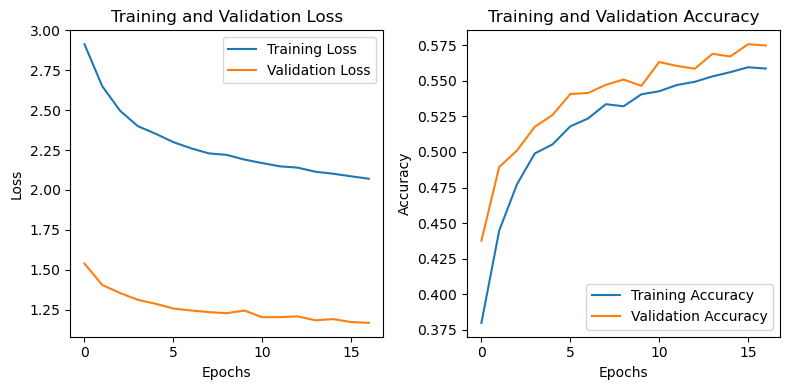

In [26]:
# Extracting training and validation loss and accuracy from history
history = hist2.history

# Plotting training and validation loss
plt.figure(figsize=(8, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

### Fulley Unfreezed Train

In [ ]:
start_epoch=len(hist2.history['loss'])
for l in base_model.layers:
    l.trainable=True
    
model.load_weights(net_description+'_ft.h5')
model.compile(optimizer=Adam(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

SECOND_EPOCHS=start_epoch+10
mc = ModelCheckpoint(net_description+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_accuracy',patience=2 )

hist3=model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples//BATCH_SIZE, 
    epochs=SECOND_EPOCHS, verbose=1, 
    initial_epoch=start_epoch, 
    validation_data=val_generator, 
    validation_steps=val_generator.samples // BATCH_SIZE, 
    callbacks=[mc],class_weight=class_weights
    )

Epoch 18/27
444/444 [==============================] - ETA: 0s - loss: 1.8238 - accuracy: 0.6208
Epoch 18: val_accuracy improved from -inf to 0.63876, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 79s 172ms/step - loss: 1.8238 - accuracy: 0.6208 - val_loss: 0.9844 - val_accuracy: 0.6388
Epoch 19/27
444/444 [==============================] - ETA: 0s - loss: 1.5385 - accuracy: 0.6685
Epoch 19: val_accuracy improved from 0.63876 to 0.65783, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 76s 170ms/step - loss: 1.5385 - accuracy: 0.6685 - val_loss: 0.9507 - val_accuracy: 0.6578
Epoch 20/27
444/444 [==============================] - ETA: 0s - loss: 1.3974 - accuracy: 0.6931
Epoch 20: val_accuracy improved from 0.65783 to 0.66829, saving model to mobilenet_face_ft.h5
444/444 [==============================] - 75s 170ms/step - loss: 1.3974 - accuracy: 0.6931 - val_loss: 0.9238 - val_accuracy: 0.6683
Epoch 21/27
444/444 [=======

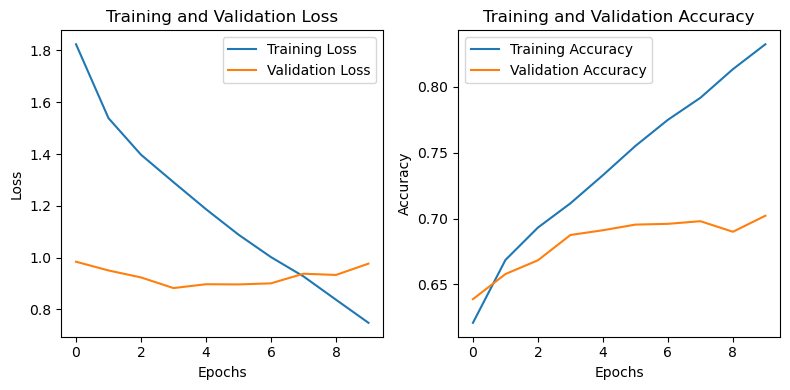

In [ ]:
history = hist3.history

# Plotting training and validation loss
plt.figure(figsize=(8, 4))

# loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()